# AnyoneAI - Sprint Project 02
> Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [3]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

In [4]:
import os
from src import config

# Delete the corrupted test file
if os.path.exists(config.DATASET_TEST):
    os.remove(config.DATASET_TEST)
    print(f"Deleted: {config.DATASET_TEST}")

# Re-download the original test file
from src import data_utils
app_train, app_test, columns_description = data_utils.get_datasets()

print(f"app_test shape after re-download: {app_test.shape}")
print(f"app_test columns: {app_test.shape[1]}")

Deleted: /Users/juanmanuelordonez/Desktop/sprint2/dataset/application_test_aai.csv


Downloading...
From: https://drive.google.com/uc?id=1sXWs2hyG34xFzRepf9fOKkCXq4kGjMT5&confirm=t
To: /Users/juanmanuelordonez/Desktop/sprint2/dataset/application_test_aai.csv
100%|██████████| 33.1M/33.1M [00:03<00:00, 8.61MB/s]


app_test shape after re-download: (61503, 122)
app_test columns: 122


### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [5]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [6]:
### TODO Complete in this cell: shape of the dataset
print("Train shape:", app_train.shape)
print("Test shape:", app_test.shape)

Train shape: (246008, 122)
Test shape: (61503, 122)


1.3. List all columns in the train dataset.

In [7]:
### TODO Complete in this cell: Show all columns in the training dataset
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [8]:
### TODO Complete in this cell: show first 5 records in a transposed table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

app_train.head().T

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
FLAG_OWN_REALTY,N,Y,Y,N,N
CNT_CHILDREN,0,1,0,0,0
AMT_INCOME_TOTAL,157500.0,90000.0,405000.0,90000.0,67500.0
AMT_CREDIT,634500.0,1223010.0,540000.0,439740.0,323388.0
AMT_ANNUITY,30523.5,51948.0,27000.0,18630.0,18054.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Value counts:
0    226257
1     19751
Name: TARGET, dtype: int64

Percentages:
0    91.97
1     8.03
Name: TARGET, dtype: float64


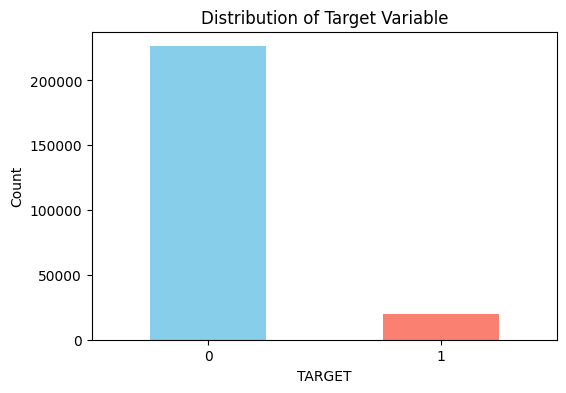

In [9]:
### TODO Complete in this cell: show distribution of target variable
# Value counts absolutos
target_counts = app_train['TARGET'].value_counts()
print("Value counts:")
print(target_counts)
print("\nPercentages:")
print((target_counts / len(app_train) * 100).round(2))
# Plot
plt.figure(figsize=(6,4))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [10]:
### TODO Complete in this cell: show number of columns per data type
# types of columns and their counts
dtype_counts = app_train.dtypes.value_counts()
print(dtype_counts)

float64    65
int64      41
object     16
dtype: int64


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [11]:
### TODO Complete in this cell: show number of unique values per categorical column
categorical_cols = app_train.select_dtypes(include=['object']).columns
unique_counts = app_train[categorical_cols].nunique().sort_values(ascending=False)
print(unique_counts)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [12]:
### TODO Complete in this cell: checking missing data
# calculte missing values
missing_values = app_train.isnull().sum()
percentage_missing = (missing_values / len(app_train) * 100).round(2)
# create dataframe
missing_data_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percentage_missing})
# filter and sort
missing_data_df = missing_data_df[missing_data_df['Missing Values'] > 0]
# sort by percentage
missing_data_df = missing_data_df.sort_values(by='Percentage', ascending=False)
missing_data_df.head(20)

,Missing Values,Percentage
COMMONAREA_MEDI,172189,69.99
COMMONAREA_AVG,172189,69.99
COMMONAREA_MODE,172189,69.99
NONLIVINGAPARTMENTS_MEDI,171096,69.55
NONLIVINGAPARTMENTS_MODE,171096,69.55
NONLIVINGAPARTMENTS_AVG,171096,69.55
FONDKAPREMONT_MODE,168561,68.52
LIVINGAPARTMENTS_MODE,168494,68.49
LIVINGAPARTMENTS_MEDI,168494,68.49
LIVINGAPARTMENTS_AVG,168494,68.49


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

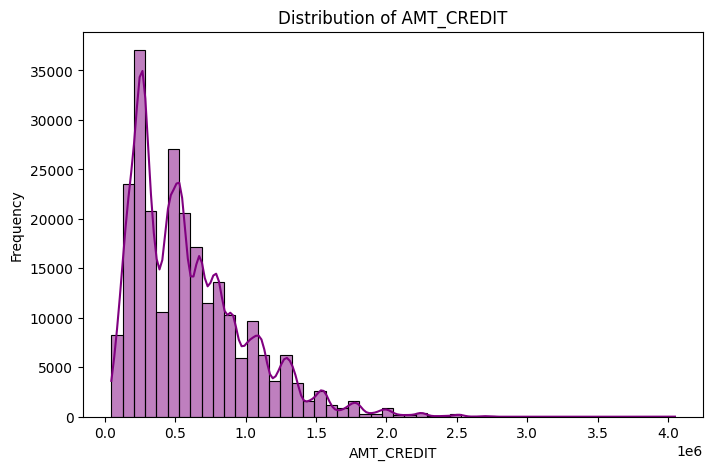

In [13]:
### TODO Complete in this cell: distribution of credit amounts
# histogram
plt.figure(figsize=(8,5))
sns.histplot(app_train['AMT_CREDIT'], bins=50, kde=True, color='purple')
plt.title('Distribution of AMT_CREDIT')
plt.xlabel('AMT_CREDIT')
plt.ylabel('Frequency')
plt.show()

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

Total counts:
Secondary / secondary special    174657
Higher education                  59990
Incomplete higher                  8248
Lower secondary                    2984
Academic degree                     129
Name: NAME_EDUCATION_TYPE, dtype: int64

Percentages:
Secondary / secondary special    71.00
Higher education                 24.39
Incomplete higher                 3.35
Lower secondary                   1.21
Academic degree                   0.05
Name: NAME_EDUCATION_TYPE, dtype: float64


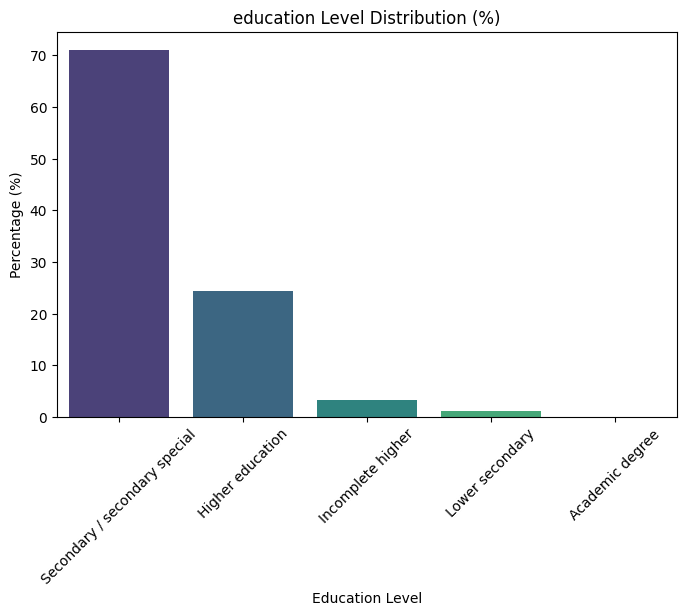

In [14]:
### TODO Complete in this cell: level of education plot
# count occurrences
edu_counts = app_train['NAME_EDUCATION_TYPE'].value_counts()
print("Total counts:")
print(edu_counts)
print("\nPercentages:")
print((edu_counts / len(app_train) * 100).round(2))
# plot
plt.figure(figsize=(8,5))
sns.barplot(x=edu_counts.index, y=(edu_counts/len(app_train) * 100), palette='viridis')
plt.title('education Level Distribution (%)')
plt.xlabel('Education Level')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()

1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

Total counts:
Laborers       44108
Sales staff    25770
Core staff     22041
Managers       16992
Drivers        14874
Name: OCCUPATION_TYPE, dtype: int64

Percentages:
Laborers                 17.93
Sales staff              10.48
Core staff                8.96
Managers                  6.91
Drivers                   6.05
High skill tech staff     3.65
Accountants               3.22
Medicine staff            2.80
Security staff            2.18
Cooking staff             1.94
Cleaning staff            1.52
Private service staff     0.87
Low-skill Laborers        0.69
Waiters/barmen staff      0.44
Secretaries               0.42
Realty agents             0.25
IT staff                  0.18
HR staff                  0.18
Name: OCCUPATION_TYPE, dtype: float64


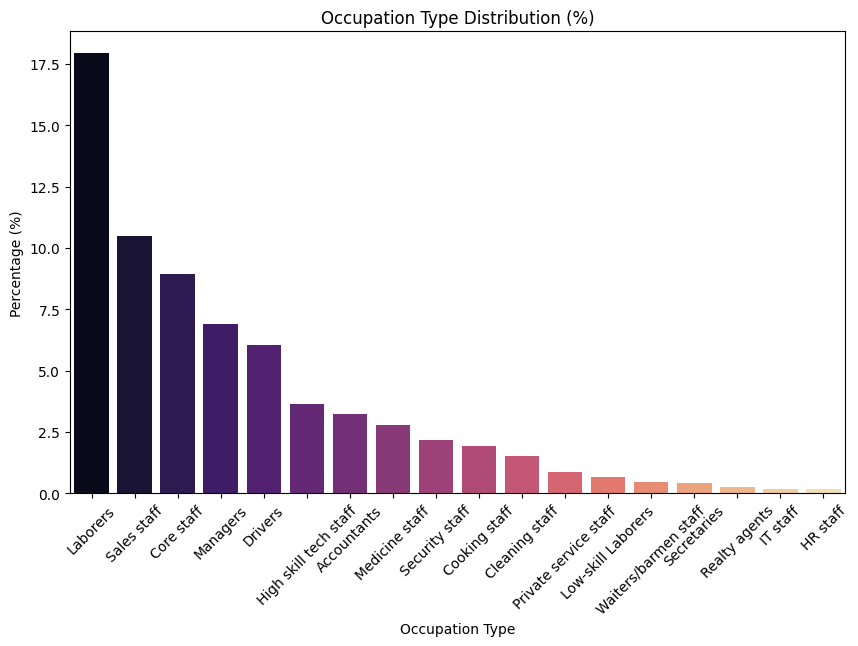

In [15]:
### TODO Complete in this cell: ocupation of applicants
occ_counts = app_train['OCCUPATION_TYPE'].value_counts()
print("Total counts:")
print(occ_counts.head())
#percentages
print("\nPercentages:")
print((occ_counts / len(app_train) * 100).round(2)) 
# plot
plt.figure(figsize=(10,6))
sns.barplot(x=occ_counts.index, y=(occ_counts / len(app_train) * 100), palette='magma')
plt.title('Occupation Type Distribution (%)')
plt.xlabel('Occupation Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()

1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

Total counts:
Married                 157165
Single / not married     36315
Civil marriage           23841
Separated                15803
Widow                    12883
Unknown                      1
Name: NAME_FAMILY_STATUS, dtype: int64

Percentages:
Married                 63.89
Single / not married    14.76
Civil marriage           9.69
Separated                6.42
Widow                    5.24
Unknown                  0.00
Name: NAME_FAMILY_STATUS, dtype: float64


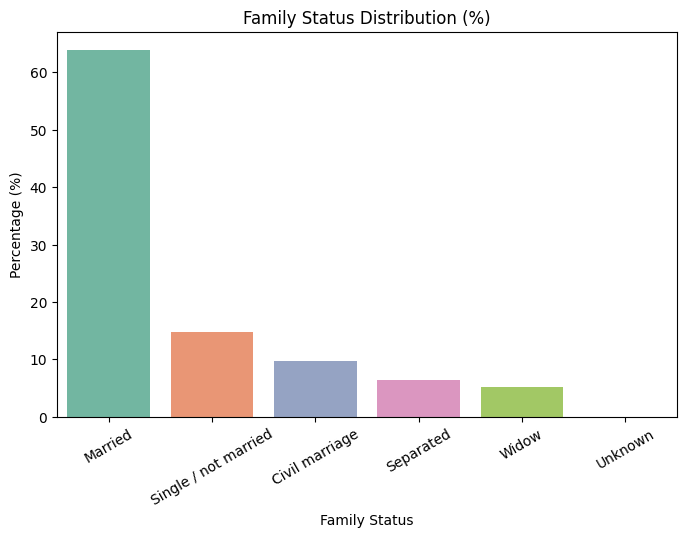

In [16]:
### TODO Complete in this cell: family status
statis_counts = app_train['NAME_FAMILY_STATUS'].value_counts()
print("Total counts:")
print(statis_counts)
print("\nPercentages:")
print((statis_counts / len(app_train) * 100).round(2))
# plot
plt.figure(figsize=(8,5))
sns.barplot(x=statis_counts.index, y=(statis_counts / len(app_train) * 100), palette='Set2')
plt.title('Family Status Distribution (%)') 
plt.xlabel('Family Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=30)
plt.show()

1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

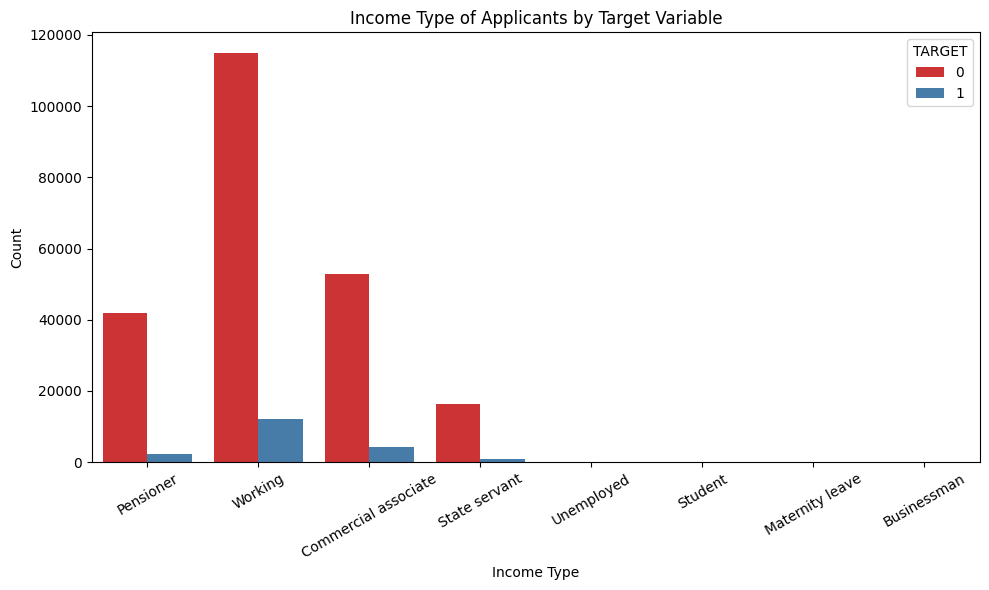

Total counts by Income Type and Target:
NAME_INCOME_TYPE      TARGET
Businessman           0              8
Commercial associate  0          52917
                      1           4273
Maternity leave       0              3
                      1              1
Pensioner             0          41902
                      1           2339
State servant         0          16411
                      1            988
Student               0             11
Unemployed            0             13
                      1              6
Working               0         114992
                      1          12144
dtype: int64


In [17]:
### TODO Complete in this cell: Income type of applicants by target variable
plt.figure(figsize=(10,6))
# countplot with hue
sns.countplot(data=app_train, x='NAME_INCOME_TYPE', hue='TARGET', palette='Set1')
plt.title('Income Type of Applicants by Target Variable')
plt.xlabel('Income Type')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# print total counts and percentages
print("Total counts by Income Type and Target:")
print(app_train.groupby(['NAME_INCOME_TYPE', 'TARGET']).size())

## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [18]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [19]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [20]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 

Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [21]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: user 6.06 s, sys: 954 ms, total: 7.01 s
Wall time: 739 ms


LogisticRegression(C=0.0001)

**Don't change anything in this cell, just make it run correctly**

In [22]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [23]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [24]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6798
Validation ROC AUC Score: 0.6772


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

    Good balance with slight underfitting

    Train AUC (0.6798) and Val AUC (0.6772) are nearly identical with only a 
    0.0026 gap, indicating excellent generalization. However, both scores are 
    moderate (~0.68), suggesting the linear model is too simple to capture all 
    patterns in the data, which is expected for logistic regression on complex 
    credit risk problems.

**Don't change anything in this cell, just make it run correctly**

In [25]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [26]:
%%time

# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train_data, y_train)


CPU times: user 1min 20s, sys: 2.17 s, total: 1min 22s
Wall time: 8.7 s


RandomForestClassifier(n_jobs=-1)

**Don't change anything in this cell, just make it run correctly**

In [27]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [28]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

3.6. Get AUC ROC score on train and validation datasets.


In [29]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train =  roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.7059


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

    Train AUC = 1.0 indicates that the model completely memorized the training data.
    Val AUC = 0.7052 shows that performance drops by about 30% on unseen data.
    The gap of nearly 0.30 is a clear sign that the model does not generalize well.
    The unregularized Random Forest built trees that were too deep, fitting very specific cases instead of
    learning general patterns.

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [30]:
%%time

# TODO Write your code here for training a Random Forest model using Random Search
# of hyper-parameters.
#   - Please use sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - Assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember to fit the model only on `train_data`.

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [5, 10, 15, 20, None],       # Profundidad máxima
    'min_samples_split': [10, 50, 100, 200],  # Muestras mínimas para dividir
    'min_samples_leaf': [5, 10, 20, 50],      # Muestras mínimas por hoja
    'max_features': ['sqrt', 'log2']          # Features para cada split
}

# Crear el modelo base
rf_base = RandomForestClassifier(n_jobs=-1, random_state=42)

# Crear RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=10,              # Número de combinaciones aleatorias a probar
    cv=5,                   # 5-fold cross validation
    scoring='roc_auc',      # Métrica de evaluación
    verbose=2,              # Mostrar progreso
    random_state=42,        # Para reproducibilidad
    n_jobs=-1               # Usar todos los cores
)

# Entrenar (esto tomará varios minutos)
rf_random.fit(train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  17.0s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  17.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  17.2s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  17.7s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  17.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=100, n_estimators=50; total time=  35.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=100, n_estimators=50; total time=  35.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=100

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10, 20, 50],
                                        'min_samples_split': [10, 50, 100, 200],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='roc_auc', verbose=2)

3.8. Use the classifier to predict probabilities on the train and test data.


In [31]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = rf_random.predict_proba(val_data)[:, 1]

3.9. Get AUC ROC score on train and validation datasets.

In [32]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8970
Validation ROC AUC Score: 0.7365


At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

    Overfitting

    Train AUC (0.897) is notably higher than Val AUC (0.737), with a gap 
    of 0.160, indicating the model fits training data better than it 
    generalizes. However, this is significantly improved compared to the 
    default Random Forest (gap of 0.295), and the validation score of 0.737 
    represents good performance for this classification task.

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [33]:
%%time

# Use best model from RandomizedSearchCV
best_rf_model = rf_random.best_estimator_

# Predict probabilities for class 1 on test data
test_preds = best_rf_model.predict_proba(test_data)[:, 1] 

# Assign predictions to app_test DataFrame
app_test["TARGET"] = test_preds

# Save to CSV - CORRECTO con config.DATASET_TEST
app_test.to_csv(config.DATASET_TEST, index=False)

# Quick sanity checks
print("Saved predictions to:", config.DATASET_TEST)
print("Test predictions min/max:", test_preds.min(), test_preds.max())
print("Sample of saved TARGET values:")
print(app_test["TARGET"].head())

Saved predictions to: /Users/juanmanuelordonez/Desktop/sprint2/dataset/application_test_aai.csv
Test predictions min/max: 0.005948896285328128 0.42308335898581295
Sample of saved TARGET values:
0    0.165133
1    0.205326
2    0.061814
3    0.173845
4    0.034954
Name: TARGET, dtype: float64
CPU times: user 2.19 s, sys: 82.6 ms, total: 2.27 s
Wall time: 1.37 s


## 5. Optional exercises

### Optional: Training a LightGBM model 

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [36]:
%%time
### Complete in this cell: train a LightGBM model
# Import LightGBM
import lightgbm as lgb
# TODO Train a LightGBM model
# 1. Create LightGBM classifier with appropriate parameters
lgbm = lgb.LGBMClassifier(
    # Basic parameters
    n_estimators=200,        # Number of boosting rounds (trees)
    learning_rate=0.05,      # How much each tree contributes (0.01-0.1)
    
    # Tree structure
    num_leaves=31,           # Max number of leaves per tree (2^max_depth - 1)
    max_depth=-1,            # No limit on depth (controlled by num_leaves)
    
    # Regularization (prevent overfitting)
    min_child_samples=20,    # Minimum samples per leaf
    subsample=0.8,           # Use 80% of data per tree
    colsample_bytree=0.8,    # Use 80% of features per tree
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=0.1,          # L2 regularization
    
    # Performance
    n_jobs=-1,               # Use all CPU cores
    random_state=42,         # For reproducibility
    
    # Other
    verbose=-1               # Suppress warnings
)
# 2. Train the model
lgbm.fit(train_data, y_train)
# 3. Predict probabilities for class 1 on validation data
lgbm_train_pred = lgbm.predict_proba(train_data)[:, 1]
lgbm_val_pred = lgbm.predict_proba(val_data)[:, 1]
# 4. Calculate ROC AUC scores
roc_auc_train = roc_auc_score(y_true=y_train, y_score=lgbm_train_pred)
print(f"LightGBM Train ROC AUC Score: {roc_auc_train:.4f}")
roc_auc_val = roc_auc_score(y_true=y_val, y_score=lgbm_val_pred)
print(f"LightGBM Validation ROC AUC Score: {roc_auc_val:.4f}")
print(f"gap between Train and Validation ROC AUC Score: {roc_auc_train - roc_auc_val:.4f}")
# 5. Compare with previous models
print("\n--- Model Comparison ---")
print(f"Logistic Regression Val AUC: 0.6772")
print(f"Random Forest Val AUC:       0.7052")
print(f"Random Forest Tuned Val AUC: 0.7365")
print(f"LightGBM Val AUC:            {roc_auc_val:.4f}")

LightGBM Train ROC AUC Score: 0.8063
LightGBM Validation ROC AUC Score: 0.7546
gap between Train and Validation ROC AUC Score: 0.0517

--- Model Comparison ---
Logistic Regression Val AUC: 0.6772
Random Forest Val AUC:       0.7052
Random Forest Tuned Val AUC: 0.7365
LightGBM Val AUC:            0.7546
CPU times: user 11.6 s, sys: 2.35 s, total: 13.9 s
Wall time: 2.54 s


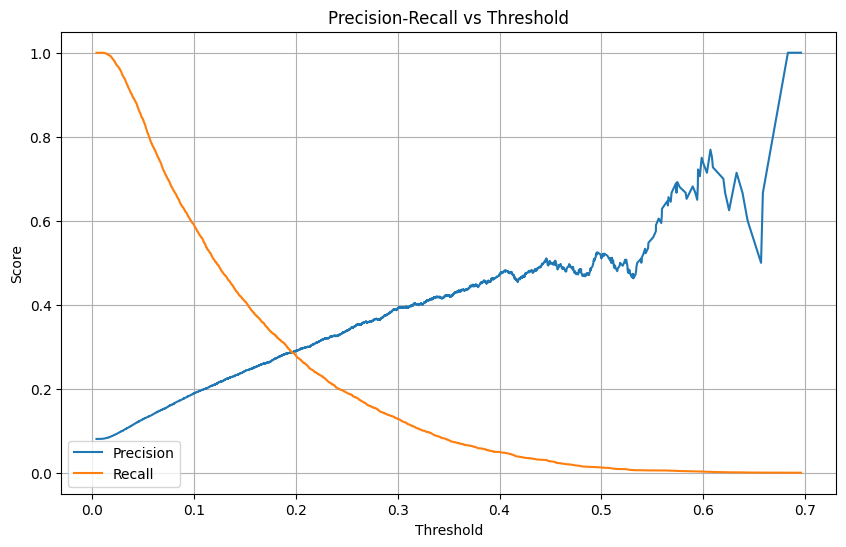

Optimal threshold (max F1): 0.15

Classification Report (threshold=0.15104700478490296):
                     precision    recall  f1-score   support

 Class 0 (Will pay)       0.94      0.89      0.92     45235
Class 1 (Won't pay)       0.24      0.41      0.30      3967

           accuracy                           0.85     49202
          macro avg       0.59      0.65      0.61     49202
       weighted avg       0.89      0.85      0.87     49202



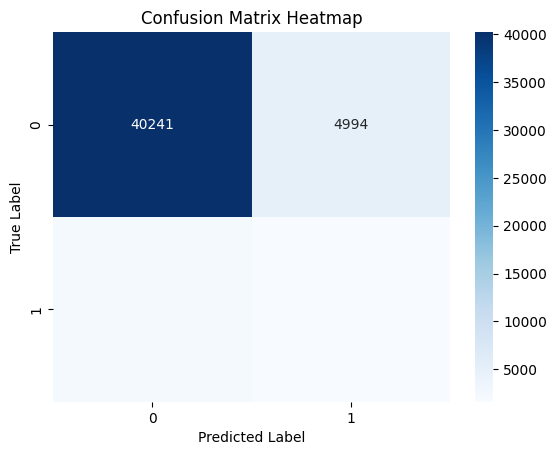


True Negatives:  40241
False Positives: 4994
False Negatives: 2357
True Positives:  1610


In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

# Calcular precision y recall para diferentes thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, lgbm_val_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar threshold que balancea precision y recall
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"Optimal threshold (max F1): {best_threshold:.2f}")

# Ajustar threshold
lgbm_val_pred_class = (lgbm_val_pred > best_threshold).astype(int)

print(f"\nClassification Report (threshold={best_threshold}):")
print(classification_report(y_val, lgbm_val_pred_class, 
                            target_names=['Class 0 (Will pay)', 'Class 1 (Won\'t pay)']))

# Confusion matrix
cm = confusion_matrix(y_val, lgbm_val_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")  # Clientes buenos rechazados
print(f"False Negatives: {cm[1,0]}")  # Clientes malos aprobados ❌
print(f"True Positives:  {cm[1,1]}")  # Clientes malos rechazados ✅

Validation AUC ROC: 0.7546



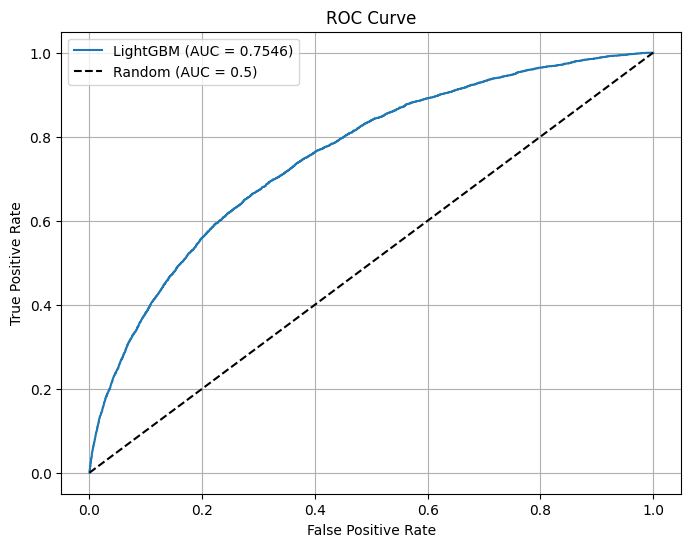

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. AUC ROC (ya lo tienes)
roc_auc_val = roc_auc_score(y_val, lgbm_val_pred)
print(f"Validation AUC ROC: {roc_auc_val:.4f}\n")

# 4. ROC Curve (visual)
fpr, tpr, thresholds = roc_curve(y_val, lgbm_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### Optional: Using Scikit Learn Pipelines 

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

Binary categorical columns: 4
Multi-class categorical columns: 12
Numeric columns: 105

Training pipeline...

PIPELINE RESULTS:
Training time: 3.78 seconds
Train AUC: 0.8058
Validation AUC: 0.7548
AUC Gap: 0.0510

Optimal threshold: 0.1500


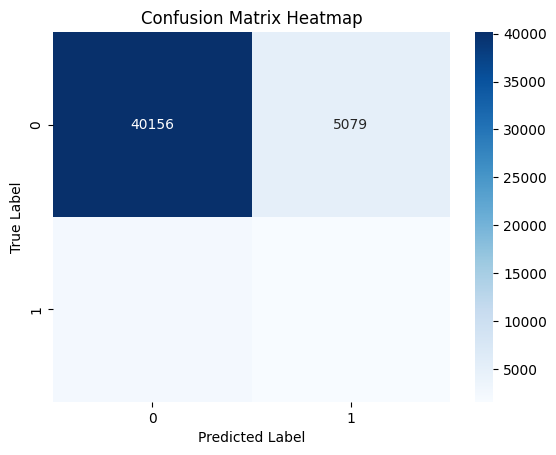


Confusion Matrix:
[[40156  5079]
 [ 2365  1602]]

Classification Report:
                     precision    recall  f1-score   support

 Class 0 (Will pay)       0.94      0.89      0.92     45235
Class 1 (Won't pay)       0.24      0.40      0.30      3967

           accuracy                           0.85     49202
          macro avg       0.59      0.65      0.61     49202
       weighted avg       0.89      0.85      0.87     49202



In [43]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from lightgbm import LGBMClassifier
import time
import numpy as np

# Load FRESH data (not the corrupted one)
app_train_fresh = pd.read_csv(config.DATASET_TRAIN)
app_test_fresh = pd.read_csv(config.DATASET_TEST)

# Split train/val
train_df, val_df = train_test_split(app_train_fresh, test_size=0.2, random_state=42, shuffle=True)

# Get features and target
X_train, y_train, _, _ = data_utils.get_feature_target(train_df, app_test_fresh)
X_val, y_val, _, _ = data_utils.get_feature_target(val_df, app_test_fresh)
X_test, y_test, _, _ = data_utils.get_feature_target(app_test_fresh, app_test_fresh)

# Fix DAYS_EMPLOYED outlier (this step stays outside the pipeline)
X_train['DAYS_EMPLOYED'] = X_train['DAYS_EMPLOYED'].replace(365243, np.nan)
X_val['DAYS_EMPLOYED'] = X_val['DAYS_EMPLOYED'].replace(365243, np.nan)
X_test['DAYS_EMPLOYED'] = X_test['DAYS_EMPLOYED'].replace(365243, np.nan)

# Identify column types (same logic as preprocessing.py)
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

binary_cols = [col for col in categorical_cols if X_train[col].nunique() == 2]
multi_cols = [col for col in categorical_cols if X_train[col].nunique() > 2]
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Binary categorical columns: {len(binary_cols)}")
print(f"Multi-class categorical columns: {len(multi_cols)}")
print(f"Numeric columns: {len(numeric_cols)}")

# Create preprocessing pipeline (same logic as preprocessing.py)
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), binary_cols),
        ('multi_class', OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cols),
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), numeric_cols)
    ]
)

# Full pipeline: preprocessing + model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        # Basic parameters
        n_estimators=200,        # Number of boosting rounds (trees)
        learning_rate=0.05,      # How much each tree contributes (0.01-0.1)
        
        # Tree structure
        num_leaves=31,           # Max number of leaves per tree (2^max_depth - 1)
        max_depth=-1,            # No limit on depth (controlled by num_leaves)
        
        # Regularization (prevent overfitting)
        min_child_samples=20,    # Minimum samples per leaf
        subsample=0.8,           # Use 80% of data per tree
        colsample_bytree=0.8,    # Use 80% of features per tree
        reg_alpha=0.1,           # L1 regularization
        reg_lambda=0.1,          # L2 regularization
        
        # Performance
        n_jobs=-1,               # Use all CPU cores
        random_state=42,         # For reproducibility
        
        # Other
        verbose=-1               # Suppress warnings
    ))
])

# Train
print("\nTraining pipeline...")
start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

# Predictions
train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
val_pred_proba = pipeline.predict_proba(X_val)[:, 1]

# Evaluate
train_auc = roc_auc_score(y_train, train_pred_proba)
val_auc = roc_auc_score(y_val, val_pred_proba)

print(f"\n{'='*50}")
print(f"PIPELINE RESULTS:")
print(f"{'='*50}")
print(f"Training time: {training_time:.2f} seconds")
print(f"Train AUC: {train_auc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"AUC Gap: {train_auc - val_auc:.4f}")
print(f"{'='*50}")

# Test predictions (save to DIFFERENT file during testing)
test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Create a copy of test dataframe with predictions
#test_submission = app_test_fresh.copy()
#test_submission['TARGET'] = test_pred_proba

# Save to a different file (not overwriting the original!)
#output_file = 'dataset/application_test_PIPELINE_predictions.csv'
#test_submission[['SK_ID_CURR', 'TARGET']].to_csv(output_file, index=False)

#print(f"\nTest predictions saved to: {output_file}")
#print(f"Prediction range: [{test_pred_proba.min():.4f}, {test_pred_proba.max():.4f}]")
# Optimal threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
#optimal_threshold = thresholds[optimal_idx]
optimal_threshold = 0.15  # You can set it manually based on the plot
print(f"\nOptimal threshold: {optimal_threshold:.4f}")

# Confusion matrix
val_pred_binary = (val_pred_proba >= optimal_threshold).astype(int)
cm = confusion_matrix(y_val, val_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')    
plt.title('Confusion Matrix Heatmap')
plt.show()
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_val, val_pred_binary, target_names=['Class 0 (Will pay)', 'Class 1 (Won\'t pay)']))

### Optional: Build your own model and features

5.3. If you want you can take the original labeled data given and make your own feature selection, data preprocessing, and model tunning. Be creative, the only limit is time and hardware resources. Only be careful and don't modify the previous functions made in the mandatory assignments or, you will break the project tests.

You can even use this newer model to make predictions in the test dataset with hidden labels and submit that.


In [8]:
%%time

# ============================================================================
# CUSTOM MODEL: XGBoost with Advanced Feature Engineering
# ============================================================================

import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src import config, data_utils, preprocessing

print("="*70)
print("CUSTOM XGBOOST MODEL WITH FEATURE ENGINEERING")
print("="*70)

# ----------------------------------------------------------------------------
# 1. FEATURE ENGINEERING
# ----------------------------------------------------------------------------
print("\n[1/5] Creating advanced features...")

# Load fresh data
app_train_custom = pd.read_csv(config.DATASET_TRAIN)
app_test_custom = pd.read_csv(config.DATASET_TEST)

def create_advanced_features(df):
    """Create domain-specific features for credit risk"""
    df = df.copy()
    
    # Credit to income ratio
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
    
    # Annuity to income ratio
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    
    # Credit to goods price ratio
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 1)
    
    # Employment to age ratio (years employed / age)
    df['EMPLOYMENT_AGE_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1)
    
    # Income per family member
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
    
    # External source weighted average
    ext_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    df['EXT_SOURCE_MEAN'] = df[ext_sources].mean(axis=1)
    df['EXT_SOURCE_MAX'] = df[ext_sources].max(axis=1)
    df['EXT_SOURCE_MIN'] = df[ext_sources].min(axis=1)
    
    # Age in years
    df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365
    
    # Employment in years
    df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df['EMPLOYMENT_YEARS'] = df['EMPLOYMENT_YEARS'].clip(upper=50)  # Cap outliers
    
    # Document submission rate
    doc_cols = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
    df['DOCS_SUBMITTED'] = df[doc_cols].sum(axis=1)
    
    # Credit bureau inquiries total
    credit_bureau_cols = [col for col in df.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
    df['CREDIT_BUREAU_TOTAL'] = df[credit_bureau_cols].sum(axis=1)
    
    return df

# Apply feature engineering
app_train_custom = create_advanced_features(app_train_custom)
app_test_custom = create_advanced_features(app_test_custom)

print(f"✓ New features created. Total columns: {app_train_custom.shape[1]}")


CUSTOM XGBOOST MODEL WITH FEATURE ENGINEERING

[1/5] Creating advanced features...
✓ New features created. Total columns: 134
CPU times: user 1.21 s, sys: 349 ms, total: 1.56 s
Wall time: 1.6 s
✓ New features created. Total columns: 134
CPU times: user 1.21 s, sys: 349 ms, total: 1.56 s
Wall time: 1.6 s


In [9]:
# ----------------------------------------------------------------------------
# 2. PREPARE DATA
# ----------------------------------------------------------------------------
print("\n[2/5] Preparing data...")

# Split features and target
X_train_custom, y_train_custom, X_test_custom, y_test_custom = data_utils.get_feature_target(
    app_train_custom, app_test_custom
)

# Train/validation split
from sklearn.model_selection import train_test_split
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_custom, y_train_custom, test_size=0.2, random_state=42, shuffle=True, stratify=y_train_custom
)

# Preprocessing
train_data_xgb, val_data_xgb, test_data_xgb = preprocessing.preprocess_data(
    X_train_xgb, X_val_xgb, X_test_custom
)

print(f"✓ Train: {train_data_xgb.shape}, Val: {val_data_xgb.shape}, Test: {test_data_xgb.shape}")


[2/5] Preparing data...
Input train data shape:  (196806, 133)
Input val data shape:  (49202, 133)
Input test data shape:  (61503, 133) 

Input train data shape:  (196806, 133)
Input val data shape:  (49202, 133)
Input test data shape:  (61503, 133) 

✓ Train: (196806, 257), Val: (49202, 257), Test: (61503, 257)
✓ Train: (196806, 257), Val: (49202, 257), Test: (61503, 257)


In [10]:
# ----------------------------------------------------------------------------
# 3. TRAIN XGBOOST MODEL
# ----------------------------------------------------------------------------
print("\n[3/5] Training XGBoost model...")

# Define XGBoost with optimized parameters for imbalanced data
xgb_model = xgb.XGBClassifier(
    # Tree parameters
    n_estimators=300,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth
    min_child_weight=5,         # Minimum sum of weights in child
    
    # Learning parameters
    learning_rate=0.05,         # Step size shrinkage (eta)
    subsample=0.8,              # Fraction of samples per tree
    colsample_bytree=0.8,       # Fraction of features per tree
    
    # Regularization
    gamma=0.1,                  # Minimum loss reduction for split
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    
    # Class imbalance handling
    scale_pos_weight=10,        # Balance positive class weight
    
    # Performance
    tree_method='hist',         # Fast histogram-based algorithm
    n_jobs=-1,                  # Use all cores
    random_state=42,
    
    # Evaluation
    eval_metric='auc',
    early_stopping_rounds=50,   # Stop if no improvement
    verbose=False
)

# Train with validation monitoring
xgb_model.fit(
    train_data_xgb, y_train_xgb,
    eval_set=[(train_data_xgb, y_train_xgb), (val_data_xgb, y_val_xgb)],
    verbose=50  # Show progress every 50 rounds
)

print(f"✓ Training completed. Best iteration: {xgb_model.best_iteration}")



[3/5] Training XGBoost model...
[0]	validation_0-auc:0.73316	validation_1-auc:0.72223
[0]	validation_0-auc:0.73316	validation_1-auc:0.72223


/Users/juanmanuelordonez/Desktop/sprint2/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-auc:0.77553	validation_1-auc:0.74773
[100]	validation_0-auc:0.79783	validation_1-auc:0.75312
[100]	validation_0-auc:0.79783	validation_1-auc:0.75312
[150]	validation_0-auc:0.81287	validation_1-auc:0.75420
[150]	validation_0-auc:0.81287	validation_1-auc:0.75420
[200]	validation_0-auc:0.82445	validation_1-auc:0.75463
[200]	validation_0-auc:0.82445	validation_1-auc:0.75463
[250]	validation_0-auc:0.83493	validation_1-auc:0.75460
[250]	validation_0-auc:0.83493	validation_1-auc:0.75460
[270]	validation_0-auc:0.83913	validation_1-auc:0.75459
✓ Training completed. Best iteration: 220
[270]	validation_0-auc:0.83913	validation_1-auc:0.75459
✓ Training completed. Best iteration: 220



[4/5] Evaluating model...

XGBOOST RESULTS:
Train AUC:      0.8290
Validation AUC: 0.7547
AUC Gap:        0.0743

--- FINAL MODEL COMPARISON ---
Logistic Regression Val AUC: 0.6772
Random Forest Val AUC:       0.7052
Random Forest Tuned Val AUC: 0.7365
LightGBM Val AUC:            0.7548
XGBoost Val AUC:             0.7547


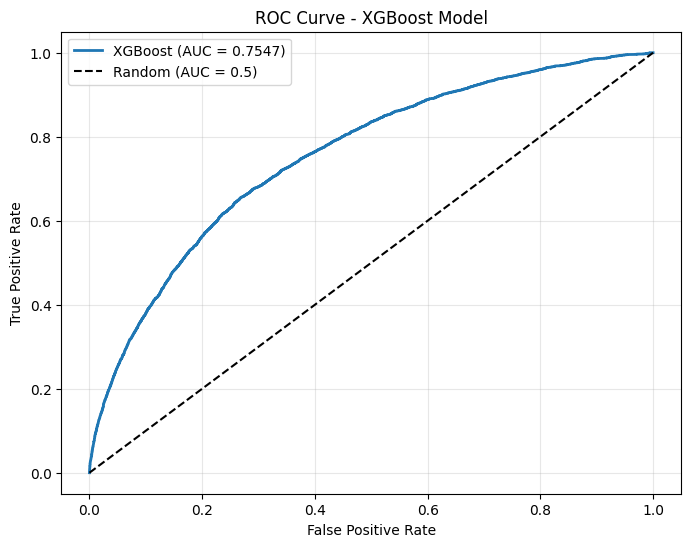


✓ Optimal threshold: 0.6354


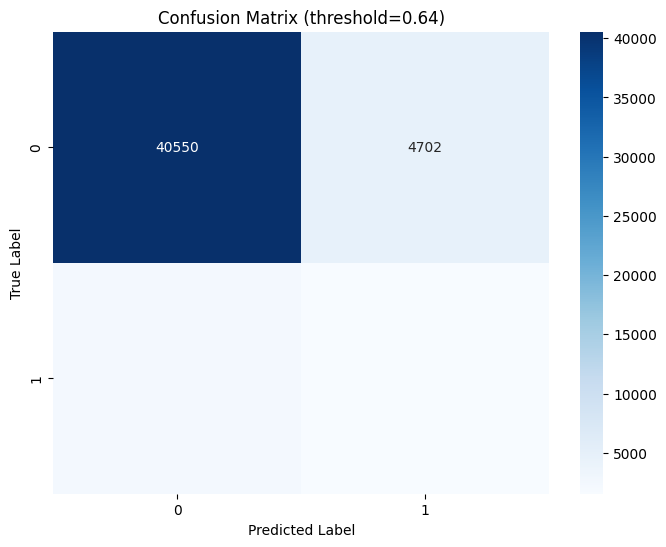


Classification Report:
                     precision    recall  f1-score   support

 Class 0 (Will pay)       0.94      0.90      0.92     45252
Class 1 (Won't pay)       0.25      0.39      0.30      3950

           accuracy                           0.86     49202
          macro avg       0.60      0.64      0.61     49202
       weighted avg       0.89      0.86      0.87     49202



In [13]:
# ----------------------------------------------------------------------------
# 4. EVALUATE MODEL
# ----------------------------------------------------------------------------
print("\n[4/5] Evaluating model...")

# Predictions
xgb_train_pred = xgb_model.predict_proba(train_data_xgb)[:, 1]
xgb_val_pred = xgb_model.predict_proba(val_data_xgb)[:, 1]

# ROC AUC Scores
train_auc_xgb = roc_auc_score(y_train_xgb, xgb_train_pred)
val_auc_xgb = roc_auc_score(y_val_xgb, xgb_val_pred)

print(f"\n{'='*70}")
print("XGBOOST RESULTS:")
print(f"{'='*70}")
print(f"Train AUC:      {train_auc_xgb:.4f}")
print(f"Validation AUC: {val_auc_xgb:.4f}")
print(f"AUC Gap:        {train_auc_xgb - val_auc_xgb:.4f}")
print(f"{'='*70}")

# Compare with all previous models
print("\n--- FINAL MODEL COMPARISON ---")
print(f"Logistic Regression Val AUC: 0.6772")
print(f"Random Forest Val AUC:       0.7052")
print(f"Random Forest Tuned Val AUC: 0.7365")
print(f"LightGBM Val AUC:            0.7548")
print(f"XGBoost Val AUC:             {val_auc_xgb:.4f}")

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val_xgb, xgb_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {val_auc_xgb:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Confusion Matrix (with optimal threshold)
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val_xgb, xgb_val_pred)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"\n✓ Optimal threshold: {optimal_threshold:.4f}")

val_pred_binary = (xgb_val_pred >= optimal_threshold).astype(int)
cm = confusion_matrix(y_val_xgb, val_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (threshold={optimal_threshold:.2f})')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val_xgb, val_pred_binary, 
                            target_names=['Class 0 (Will pay)', 'Class 1 (Won\'t pay)']))

